### Image Classification - Number vs Nonumber (Part 1)

> In lesson1 v2 of fast.ai, we learned "cats vs dogs" image classification.  The probability of the image being a cat or a dog.  In this notebook, I set to replicate lesson1 and create an image classifier that recognizes pictures with or without number(s).   The sample datasets are collected from "Street View Home Number" and "Cifar10" datasets.<br><br>
> I will interact quickly at first(in this notebook) with a smaller sample size to see if the basic classification works and if there is any code to debug.  After ensuring that classification works in general, I will use the entire SVHN datasets to train, validation and test, in a next notebook.<br>

***Steps learned from lesson1***
1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from shutil import copyfile
import cv2
import glob

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
# Functions used to plot images:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))



In [6]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [7]:
# Source: https://gist.github.com/surmenok/8de6fd87af5f3dfe72e84ccaf690167e
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [8]:
# Create "number" datasets paths. 
PATH = 'data/sample_numbers/'

# 1) SVHN sample datasets already exist.
# 2) data/numbers/ directory already exist.
# 3) Use f-strings to name paths.

In [9]:
os.listdir(f'{PATH}') 

['models', 'train', 'valid', 'tmp', 'test']

In [10]:
os.listdir(f'{PATH}/train')

['nonumber', 'number']

In [11]:
os.listdir(f'{PATH}/valid')

['nonumber', 'number']

In [12]:
# Print specific file type, file q'ty in a folder, and file names. 
def folder_inf(folder, formato):
    file_names = []
    for i in folder.rglob(formato):
        s = i.name
        file_names.append(s)
    print('Total number of images(type {}) in folder "{}" is "{}".'.format(formato, folder,
                                                                           len(file_names)))
    return(file_names)

# Shuffle files randomly within a folder.
def shuf_folder(folder, formato):
    shuf = []
    for i in folder.rglob(formato):
        s = i.name
        shuf.append(s)
    random.shuffle(shuf)
    return(shuf)

# Copy from source to target folder
def copy_f1tof2(tocopy, source, target):
    for i in range(len(tocopy)):
        copyfile(str(source/tocopy[i]), str(target/tocopy[i]))

In [13]:
# Create random images, 1000 images to 'sample_numbers/train/number' and 200 images to 
#   'sample_numbers/valid/number' from 'svhn/train' folder
source_A = Path('data/svhn/train')
shuf = shuf_folder(source_A, '*.png')
train_no = shuf[0:1000]
val_no = shuf[1000:1200]
train_num = Path(f'{PATH}train/number') 
val_num = Path(f'{PATH}valid/number')
#copy_f1tof2(train_no, source_A, train_num)
#copy_f1tof2(val_no, source_A, val_num)

In [14]:
# Create access to Cifar10, copy randomly 12 images from each category and paste the
#   1001 images to "data/numbers/train/nonumber" and 201 to "data/numbers/val/nonumber"
C = Path('data/cifar10/train')
c10_cat = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
          'truck']
for i in range(len(c10_cat)):
    source = (C/f'{c10_cat[i]}/')
    shuf = shuf_folder(source, '*.png*')
    train_no = shuf[0:100]
    val_no = shuf[100:120]
    train_nonum = Path(f'{PATH}train/nonumber') 
    val_nonum = Path(f'{PATH}valid/nonumber')
    #copy_f1tof2(train_no, source, train_nonum)
    #copy_f1tof2(val_no, source, val_nonum)

In [15]:
# Function to change the name of the files.
def change_f_names(path, name, formato):
    files = sorted(os.listdir(path))
    for idx, file in enumerate(files):
        new_name = (f'{name}{idx:06}{formato}')
        os.rename(os.path.join(path, file), \
              os.path.join(path, new_name))

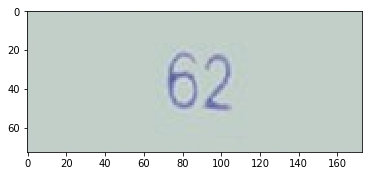

In [16]:
# Images from "train/number" folder:
files = os.listdir(f'{PATH}/train/number/')[:5]
img = plt.imread(f'{PATH}/train/number/{files[0]}')
plt.imshow(img)

In [17]:
img.shape

(73, 173, 3)

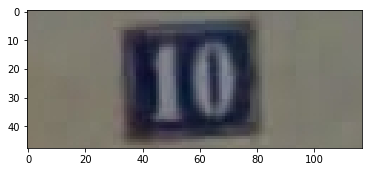

In [18]:
# Images from "valid/number" folder:
files_1 = os.listdir(f'{PATH}/valid/number/')[:5]
img_1 = plt.imread(f'{PATH}/valid/number/{files_1[3]}')
plt.imshow(img_1)

In [19]:
img_1.shape

(48, 117, 3)

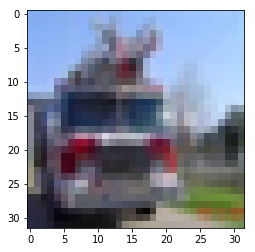

In [20]:
# Images from "train/nonumber" folder:
files_2 = os.listdir(f'{PATH}/train/nonumber/')[:5]
img_2 = plt.imread(f'{PATH}/train/nonumber/{files_2[0]}')
plt.imshow(img_2)

In [21]:
img_2.shape

(32, 32, 3)

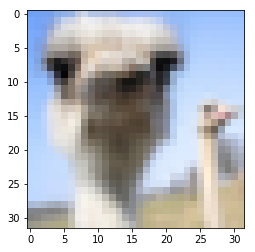

In [22]:
# Images from "valid/nonumber" folder:
files_3 = os.listdir(f'{PATH}/valid/nonumber/')[:5]
img_3 = plt.imread(f'{PATH}/valid/nonumber/{files_3[0]}')
plt.imshow(img_3);

In [23]:
img_3.shape

(32, 32, 3)

In [24]:
# Change image names. Ex: "18660_ship.png" to 'nonumber_1.png', '47242_airplane.png" to "nonumber_2.png", etc.
# os.listdir(f'{PATH}/train/nonumber')[0:5]

In [25]:
path = f'{PATH}/train/nonumber'
name = 'nonumber'
formato = '.png'
# change_f_names(path, name, formato)
os.listdir(f'{PATH}/train/nonumber')[0:5]

['nonumber000533.png',
 'nonumber000472.png',
 'nonumber000450.png',
 'nonumber000718.png',
 'nonumber000322.png']

In [26]:
# Change image names. Ex: "18569.png" to 'number_1.png', '12985.png" to "number_2.png", etc.
# os.listdir(f'{PATH}/train/number')[0:5]

In [27]:
path = f'{PATH}/train/number'
name = 'number'
formato = '.png'
# change_f_names(path, name, formato)
os.listdir(f'{PATH}/train/number')[0:5]

['number000398.png',
 'number000773.png',
 'number000184.png',
 'number000712.png',
 'number000772.png']

In [28]:
# Change image names. Ex: "18660_ship.png" to 'nonumber_1.png', '47242_airplane.png" to "nonumber_2.png", etc.
# os.listdir(f'{PATH}/valid/nonumber')[0:5]

In [29]:
path = f'{PATH}/valid/nonumber'
name = 'nonumber'
formato = '.png'
# change_f_names(path, name, formato)
os.listdir(f'{PATH}/valid/nonumber')[0:5]

['nonumber000185.png',
 'nonumber000175.png',
 'nonumber000128.png',
 'nonumber000118.png',
 'nonumber000164.png']

In [30]:
# Change image names. Ex: "18569.png" to 'number_1.png', '12985.png" to "number_2.png", etc.
# os.listdir(f'{PATH}/valid/number')[0:5]

In [31]:
path = f'{PATH}/valid/number'
name = 'number'
formato = '.png'
# change_f_names(path, name, formato)
os.listdir(f'{PATH}/valid/number')[0:5]

['number000184.png',
 'number000039.png',
 'number000133.png',
 'number000175.png',
 'number000071.png']

#### **Initial Setting**:
Follow settings from first part of lesson1<br>
1) arch = Resnet34(pretrained Imagenet)<br>
2) sz = 32<br>
3) bs = 64(default)<br>
4) lr = 0.01 <br>
5) epoch = 2 <br>
6) precompute = True<br>
7) data augmentation = False<br> 
8) images in folders:<br>
"train/nonumber" = 100 (Cifar10) <br>
"train/number" = 100 (SVHN)<br>
"valid/nonumber" = 20 (Cifar10)<br>
"valid/number" = 20 (SVHN)<br>
9) label naming: ex. "xxxx_ship.png" for nonumber; "xxxx.png" for number. 

In [32]:
arch = resnet34
sz = 32

data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(0.01, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.135177   0.079745   0.9775    
    1      0.086699   0.062042   0.975                       



[array([0.06204]), 0.975]

High accuracy at first trial, but underfitting.

In [33]:
learn.lr_find()

A Jupyter Widget

 75%|███████▌  | 24/32 [00:00<00:00, 103.44it/s, loss=0.273] 


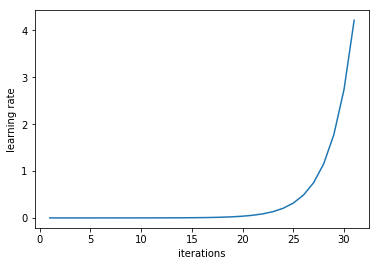

In [34]:
learn.sched.plot_lr()

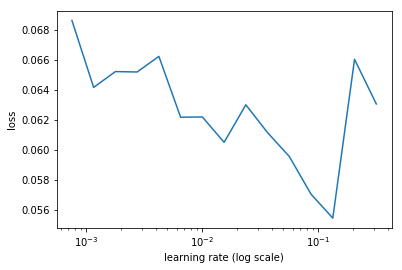

In [35]:
learn.sched.plot() # Printing graph, but quite strange curve!!

In [36]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 

In [37]:
data.classes

['nonumber', 'number']

In [38]:
# Validation datasets, 20 images from nonumber and 20 from number.
log_preds = learn.predict()
log_preds.shape

(400, 2)

In [39]:
log_preds[:10]

array([[ -0.0273 ,  -3.61431],
       [ -0.00258,  -5.96133],
       [ -0.00021,  -8.47427],
       [ -0.00001, -11.26342],
       [ -0.2792 ,  -1.41218],
       [ -0.00057,  -7.4756 ],
       [ -0.00015,  -8.83131],
       [ -0.00426,  -5.45972],
       [ -0.00198,  -6.22453],
       [ -0.     , -13.71307]], dtype=float32)

In [40]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1]) # pr that it is a number    

Correctly classified


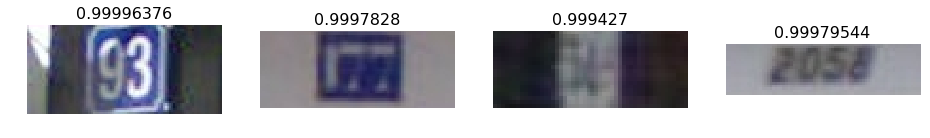

In [41]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


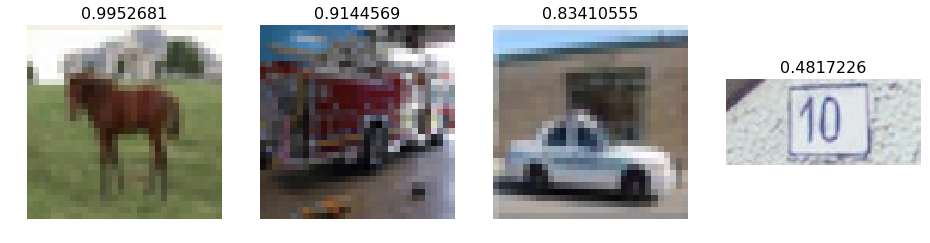

In [42]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct nonumber


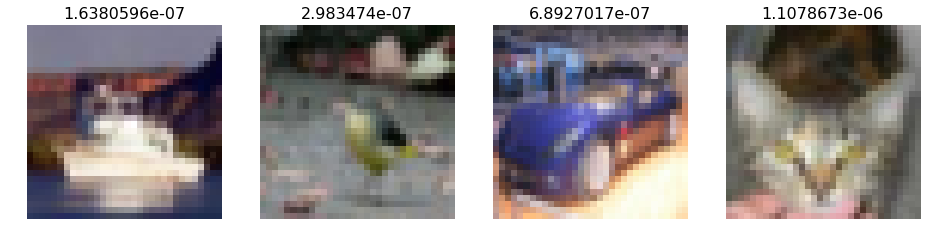

In [43]:
plot_val_with_title(most_by_correct(0, True), "Most correct nonumber")

Most correct number


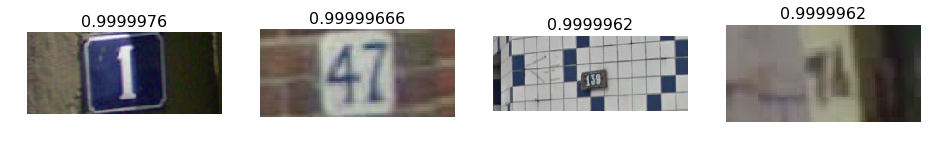

In [44]:
plot_val_with_title(most_by_correct(1, True), "Most correct number")

Most incorrect nonumber


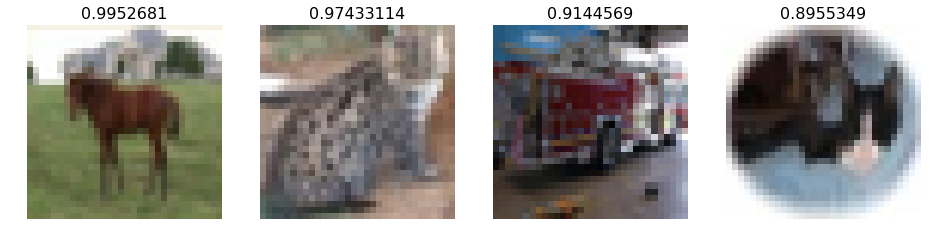

In [45]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect nonumber")

Most incorrect number


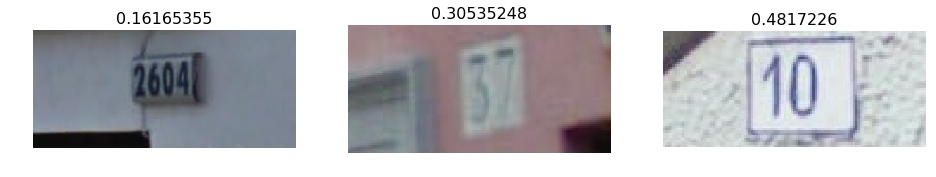

In [46]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect number")

Most uncertain predictions


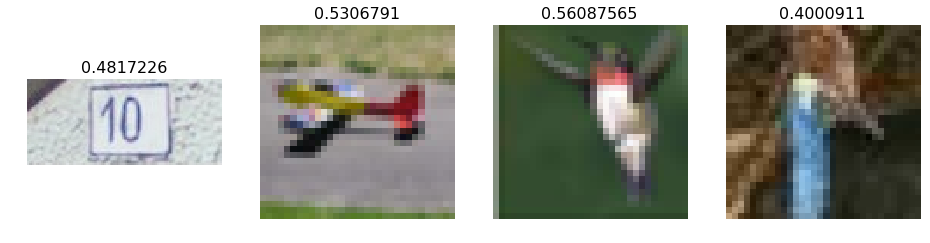

In [47]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

The same settings used in Lesson 1 works for SVHN and Cifar10 datasets as well.  I will increase the datasize in Part2.  

#### Lesson's Learned
i) Use variable "PATH" when using function "ImageClassifierData.from_paths(PATH)".  When I used another variable name, for ex. "PATH_1", it did not find the correct paths.<br>
ii) Follow the same path naming rules for the entire notebook.  If you start with f-strings "f'{PATH}/train'", for example, use it all the way.  If for some reason you use both f-strings and pathlib, it can create confusion.<br>
iii) Diminish the bs when your datasets are small.  'learn.sched.plot()' will not plot until when you set bs lower.<br>
iv) When you change folder names or variable settings, ex. train, valid, test, or bs, make sure you add this changes to ImageClassifierData.from_paths() as well.<br>
iv) Starting with samples of 100(train) and 20(valid), is probably the same as starting with 1000(train) and 200(valid).  Start with the ladder next time, it won't make much difference in training time.<br>
v) Use OpenCV to read the image, but use matplotlib to plot(display).  It is easier to use OpenCV in ".png" format than in matplotlib.<br> 


#### Questions:
a) How do you perform inference with 'testing' datasets?<br>
b) How do you know when the weights are from Imagenet?<br>
c) Other than image size, what other characteristics should you analyze from the image?<br>
d) A 'tmp' folder was created with "x_act_resnet34_0_32.bc", "x_act_resnet34_0_32.bc", and "x_act_val_resnet34_0_32.bc".  What are they and why were they created? <br>
e) A 'model' folder was created with 'tmp.h5'.  What is it for? <br>
f) How to find the image size and resolution using fastai library? <br>
g) Does the resolution matter or only the size? What is the difference between the 2 anyway?<br>
h) What would happen if I don't use any transfer learning and train "only" SVHN datasets? <br>
i) Instead of using Cifar10 datasets as "nonumber" images, if I change the datasets to "street sign or post" images, but without any number.  Would this type of images has more resemblance with "Street View House Number" images, and therefore improve its accuracy?<br>
j) Should I change the file names to "number_x.png"(x being number 1, 2, 3,..., n) for folder number and "nonumber_x.png"(x being number 1, 2, 3,..., n) for folders nonumber?  Or can the names be different?  Would that change the accuracy?

***The above questions will replied in Part2 of this notebook.**




### End